In [1]:
using Revise

In [3]:
using PyCall, PyPlot, Statistics
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [4]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting

┌ Info: Precompiling ClimateMARGO [d3f62095-a717-45bf-aadc-ac9dfc258fa6]
└ @ Base loading.jl:1278


## Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [5]:
model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]))
@time optimize_controls!(model, obj_option = "net_benefit");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 22.005353 seconds (48.08 M allocations: 2.399 GiB, 5.13% gc time)


In [6]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxgeoeng" => [], "maxTnoG" => [], "maxT" => [], "maxCO2" => [])
ρdict = Dict()
ρs = 0.:0.0025:0.075

for ρ in ρs
    tmp_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));
    tmp_model.economics.ρ = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    q = model.economics.baseline_emissions
    Midx = q .> 0.
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate[Midx]))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["maxTnoG"], maximum(T(tmp_model, M=true, R=true)))
    append!(stat_dict["maxT"], maximum(T_adapt(tmp_model, M=true, R=true, G=true, A=true)))
    append!(stat_dict["maxCO2"], maximum(c(tmp_model, M=true, R=true)))
end

Solve_Succeeded
  0.055338 seconds (100.42 k allocations: 4.044 MiB)
Solve_Succeeded
  0.058317 seconds (104.90 k allocations: 4.138 MiB)
Solve_Succeeded
  0.055978 seconds (100.42 k allocations: 4.044 MiB)
Solve_Succeeded
  0.055769 seconds (100.54 k allocations: 4.054 MiB)
Solve_Succeeded
  0.053458 seconds (96.06 k allocations: 3.959 MiB)
Solve_Succeeded
  0.052763 seconds (87.45 k allocations: 3.800 MiB)
Solve_Succeeded
  0.049365 seconds (82.97 k allocations: 3.705 MiB)
Solve_Succeeded
  0.048104 seconds (82.97 k allocations: 3.705 MiB)
Solve_Succeeded
  0.055313 seconds (91.82 k allocations: 3.885 MiB)
Solve_Succeeded
  0.047339 seconds (78.60 k allocations: 3.621 MiB)
Solve_Succeeded
  0.046517 seconds (78.60 k allocations: 3.621 MiB)
Solve_Succeeded
  0.052923 seconds (87.45 k allocations: 3.800 MiB)
Solve_Succeeded
  0.052153 seconds (82.97 k allocations: 3.705 MiB)
Solve_Succeeded
  0.109761 seconds (83.49 k allocations: 3.891 MiB, 43.42% gc time)
Solve_Succeeded
  0.048471 s

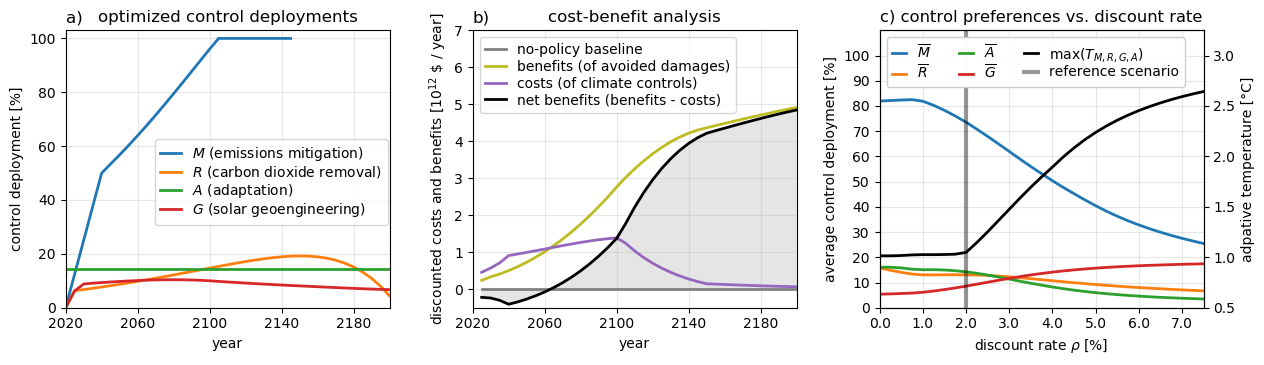

Maximum warming: 1.0479619451157705

In [7]:
fig = figure(figsize=(12.75,3.75))

fig.add_subplot(1,3,1)
plot_controls(model)
legend(handlelength=1.5, loc=(0.275, 0.30), labelspacing=0.1)
title("a)", loc="left")
ylim(0, 1.03)

ax = fig.add_subplot(1,3,2)
plot_benefits(model, discounting=true)
legend(handlelength=1.5, loc="upper left", labelspacing=0.2)
title("b)", loc="left")
ylim([-0.5, 7.])

ax = fig.add_subplot(1,3,3)
plot(ρs, stat_dict["mitigate"], lw=2, label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], lw=2, label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], lw=2, label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], lw=2, label=L"$\overline{G}$")
plot([], [], "k-", lw=2, label=L"$\max(T_{M,R,G,A})$")
#plot(ρs, 1 .-(stat_dict["mitigate"]+stat_dict["remove"]+ stat_dict["adapt"]+stat_dict["geoeng"]), "k-", lw=2, label=L"$\max(T_{M,R,G,A})$")

axt = ax.twinx()  # instantiate a second axes that shares the same x-axis
axt.set_ylabel("adpative temperature [°C]")  # we already handled the x-label with ax1
axt.tick_params(axis="y")
axt.plot(ρs, stat_dict["maxT"], "k-", lw=2, label=L"$\max(T_{M,R,G,A})$")
axt.set_ylim(0.5, 3.25)

ax = fig.add_subplot(1,3,3)
axvline(model.economics.ρ, color="k", label="reference scenario", alpha=0.4, lw=3)
legend(ncol=3, handlelength=1., labelspacing=0.14, loc="upper left", framealpha=0.99)
ylim([0, 1.1])
xlim([0., 0.075])
xticks(0:0.01:0.075, 0:1:7.5)
yticks(0:0.1:1, 0:10:100)
grid(true, alpha=0.3)
ylabel("average control deployment [%]")
title("c) control preferences vs. discount rate", loc="left", fontsize=11.75)
xlabel(L"discount rate $\rho$ [%]")

tight_layout()
savefig("figures/cost-benefit-analysis.png", dpi=200, bbox_inches="tight")

print("Maximum warming: ", maximum(T_adapt(model, M=true, R=true, G=true, A=true)))

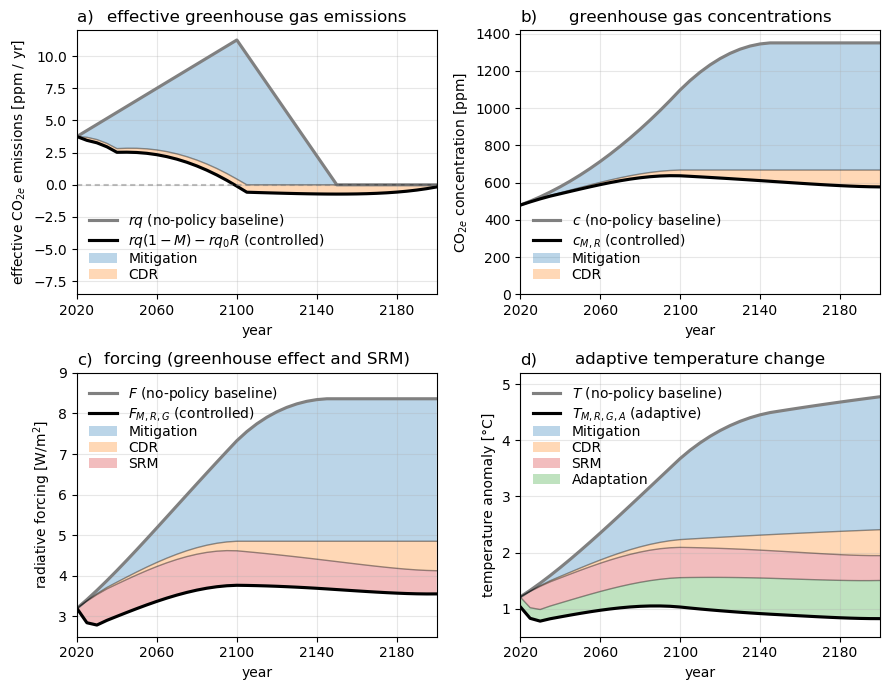

In [8]:
figure(figsize=(9,7))

subplot(2,2,1)
plot_emissions(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("a)", loc="left")
ylim(-8.5, 12)
subplot(2,2,2)
plot_concentrations(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("b)", loc="left")
subplot(2,2,3)
plot_forcings(model)
legend(loc="upper left", labelspacing=0.14, framealpha=0., fontsize=10)
title("c)", loc="left")
ylim(2.5, 9)
tight_layout()
subplot(2,2,4)
plot_temperatures(model, temp_goal=0.)
legend(loc="upper left", labelspacing=0.14, framealpha=0., fontsize=10)
title("d)", loc="left")
ylim(0.5, 5.2)
tight_layout()
savefig("figures/cost-benefit-outcomes.png", dpi=200, bbox_inches="tight")

In [9]:
model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]))
model.economics.ρ = 0.075
@time optimize_controls!(model, obj_option = "net_benefit");

Solve_Succeeded
  0.057604 seconds (100.42 k allocations: 4.044 MiB)


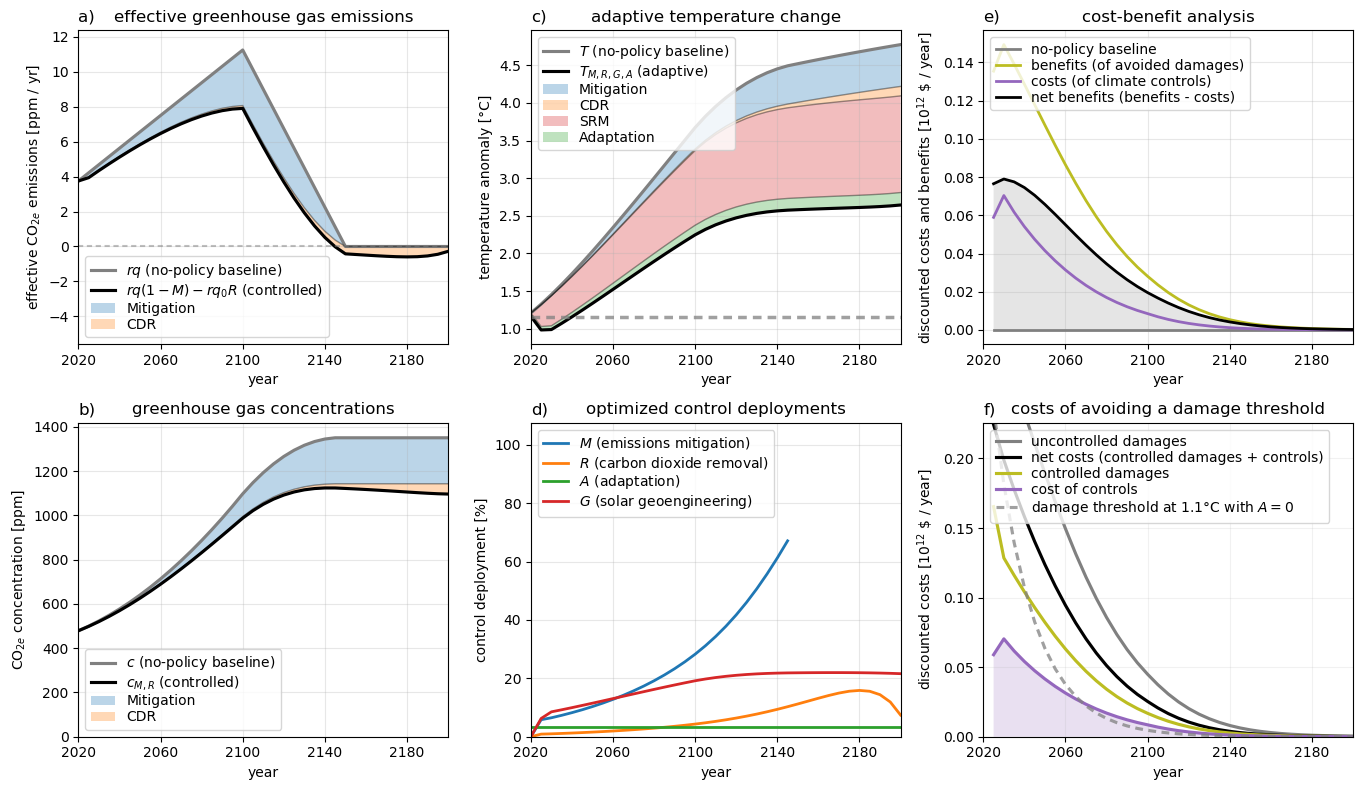

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fc80ea7e978>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fc8128919b0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fc80f6c30f0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fc8128bbf60>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fc8110f6400>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fc81247f550>])

In [10]:
plot_state(model)

#### Approach 2: Avoiding damage thresholds

In [11]:
model = ClimateModel(ClimateMARGO.IO.included_configurations["default"])
@time optimize_controls!(model);

Solve_Succeeded
  0.063359 seconds (101.31 k allocations: 3.933 MiB)


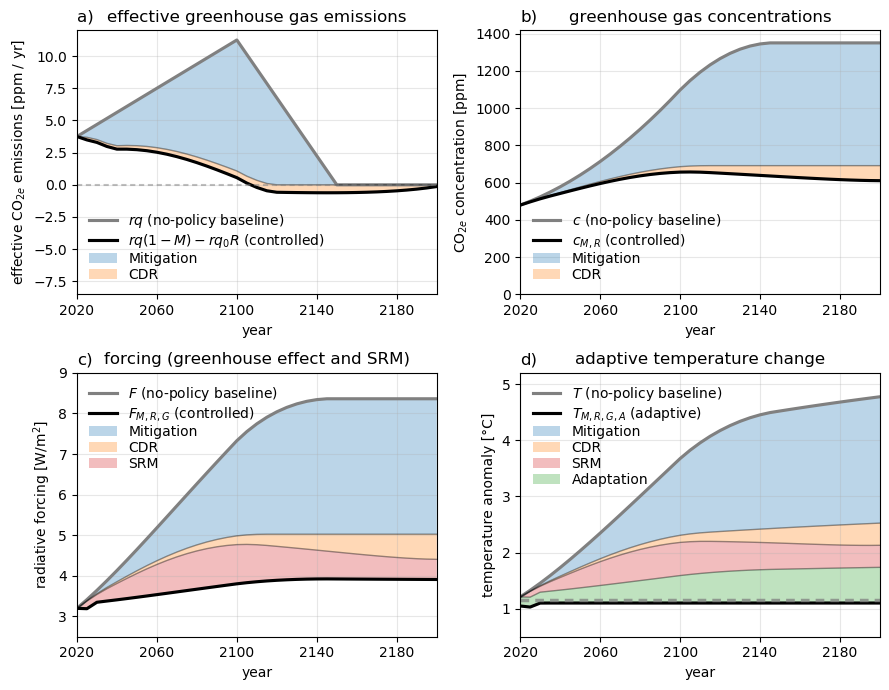

In [12]:
figure(figsize=(9,7))

subplot(2,2,1)
plot_emissions(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("a)", loc="left")
ylim(-8.5, 12)
subplot(2,2,2)
plot_concentrations(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("b)", loc="left")
subplot(2,2,3)
plot_forcings(model)
legend(loc="upper left", labelspacing=0.14, framealpha=0., fontsize=10)
title("c)", loc="left")
ylim(2.5, 9)
tight_layout()
subplot(2,2,4)
plot_temperatures(model)
legend(loc="upper left", labelspacing=0.14, framealpha=0., fontsize=10)
title("d)", loc="left")
ylim(0.5, 5.2)
tight_layout()
savefig("figures/cost-effectiveness-outcomes.png", dpi=200, bbox_inches="tight")

In [ ]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

ρs = 0.:0.001:0.05
CGs = 0.:0.004:0.24;
models = Array{ClimateModel}(undef, size(ρs,1), size(CGs,1));

for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        tmp = deepcopy(base_model)
        tmp.economics.ρ = ρ
        tmp.economics.geoeng_cost = CG
        optimize_controls!(tmp, print_raw_status=false)
        models[i, j] = tmp
    end
end

GFmax = Array{Float64}(undef, size(ρs,1), size(CGs,1));
percent_Gcool = Array{Float64}(undef, size(ρs,1), size(CGs,1));
for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        GFmax[i,j] = maximum(F(models[i,j], M=true, R=true) - F(models[i,j], M=true, R=true, G=true))
        TN = sum(T(models[i,j]) .- 1.1)
        TM = sum(T(models[i,j]) .- T(models[i,j], M=true)) / TN
        TR = sum(T(models[i,j], M=true) .- T(models[i,j], M=true, R=true)) / TN
        TG = sum(T(models[i,j], M=true, R=true) .- T(models[i,j], M=true, R=true, G=true)) / TN
        TA = sum(T(models[i,j], M=true, R=true, G=true) .- T_adapt(models[i,j], M=true, R=true, G=true, A=true)) / TN
        percent_Gcool[i,j] = deepcopy(TG)
    end
end

In [ ]:
figure(figsize=(8.75,3.5))

subplot(1,2,1)
plot_controls(model)
legend(loc=(0.285, 0.25), labelspacing=0.16, framealpha=0.95)
title("a)", loc="left")

subplot(1,2,2)
plot_damages(model)
legend(loc="upper right", labelspacing=0.16, framealpha=0.97, handlelength=1.3)
title("")
title("b) costs of avoiding a damage threshold", loc="left")
ylim([0, 6.0])

tight_layout(w_pad=0.025)
savefig("figures/cost-effectiveness-analysis.png", dpi=200, bbox_inches="tight")

print("Net Present Control Costs = ", net_present_cost(model, M=true, R=true, G=true, A=true), " trillion USD")

figure(figsize=(4.75,3.5))
percent_lev = 0:10:100
contourf(CGs, ρs, percent_Gcool*100, cmap="Reds", levels=percent_lev, extend="max")
colorbar(label = "SRM share of adaptive cooling [%]", ticks=percent_lev)
plot([base_model.economics.geoeng_cost], [base_model.economics.ρ], color="grey", "o", label="reference scenario", markeredgecolor="k", markersize=8, markeredgewidth=0.7)
annotate("reference\nscenario", (base_model.economics.geoeng_cost + 0.008, base_model.economics.ρ - 0.0021))
yticks(0.:0.01:0.05, 0:1:5)
xticks(0.:0.02:0.24, 0:2:24)
xlabel(L"SRM scaling cost $\mathcal{C}_{G}$ [% GWP per 8.5 W/m$^{2}$]")
ylabel(L"discount rate $\rho$ [%]")
title("sensitivity of optimized SRM")
savefig("figures/cost-effectiveness-analysis-sensitivity.png", dpi=200, bbox_inches="tight")

# subplot(1,3,3)
# GFlev = 0.:0.5:4
# contourf(CGs, ρs, GFmax, cmap="Greys", levels=GFlev, extend="max")
# colorbar(label = L"maximum SRM cooling [W/m$^{2}$]", ticks=GFlev)
# plot([base_model.economics.geoeng_cost], [base_model.economics.ρ], "ro", label="reference scenario", markeredgecolor="k", markersize=8, markeredgewidth=0.7)
# annotate("reference\nscenario", (base_model.economics.geoeng_cost + 0.008, base_model.economics.ρ - 0.0021))
# yticks(0.:0.01:0.05, 0:1:5)
# xticks(0.:0.02:0.2, 0:2:20)
# xlabel(L"SRM scaling cost $\mathcal{C}_{G}$ [% GWP]")
# ylabel(L"discount rate $\rho$ [%]")
# title("sensitivity of optimal SRM")
# title("c)", loc="left")

In [ ]:
5*0.18/(model.economics.β*100*(1.5^2))

In [ ]:
(model.economics.β*100*(1.5^2))^2

In [ ]:
(model.economics.β*100*(1.5^2))^2 / (25*0.71)

In [ ]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

CRs = 0.:1.0:50.0
CMs = 0.:0.005:0.2;
models = Array{ClimateModel}(undef, size(CRs,1), size(CMs,1));

for (i, CR) in enumerate(CRs)
    for (j, CM) in enumerate(CMs)
        tmp = deepcopy(base_model)
        tmp.economics.mitigate_cost = CM
        tmp.economics.remove_cost = CR
        optimize_controls!(tmp, print_raw_status=false)
        models[i, j] = tmp
    end
end

percent_Mcool = Array{Float64}(undef, size(CRs,1), size(CMs,1));
percent_Rcool = Array{Float64}(undef, size(CRs,1), size(CMs,1));
for (i, CR) in enumerate(CRs)
    for (j, CM) in enumerate(CMs)
        TN = sum(T(models[i,j]) .- 1.1)
        TM = sum(T(models[i,j]) .- T(models[i,j], M=true)) / TN
        TR = sum(T(models[i,j], M=true) .- T(models[i,j], M=true, R=true)) / TN
        TG = sum(T(models[i,j], M=true, R=true) .- T(models[i,j], M=true, R=true, G=true)) / TN
        TA = sum(T(models[i,j], M=true, R=true, G=true) .- T_adapt(models[i,j], M=true, R=true, G=true, A=true)) / TN
        percent_Mcool[i,j] = deepcopy(TM)
        percent_Rcool[i,j] = deepcopy(TR)
    end
end

In [ ]:
contourf(CMs, CRs, percent_Rcool*100, cmap="Blues", levels=percent_lev)
ylabel(L"$\mathcal{C}_{R}$")
xlabel(L"$\mathcal{C}_{M}$")
colorbar()